In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Factorization Machine
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

from factorization_machine import FactorizationMachine as OriginalFactorizationMachine

# BQM
import dimod

In [28]:
var_num = 16    # number of vars in bqm

In [29]:
def custom_bias_generator(var_num):
    return np.random.uniform(-1, 1, var_num)

bqm = dimod.generators.gnm_random_bqm( # 用來生成一個隨機的BQM
          variables = var_num,  #指定BQM有var_num個二元變數
          num_interactions = var_num*(var_num-1)/2,  #指定二次項的數量
          vartype = dimod.BINARY, #指定變數類型為二元
          bias_generator=custom_bias_generator
      )

In [30]:
b = bqm.offset       # bias     -> type: 0-D numpy 偏移量
h = bqm.linear       # linear   -> type: dict like 線性項
Q = bqm.quadratic    # coupling -> type: dict like 二次項

In [31]:
# 將字典格式的 h 和 Q 轉換為numpy陣列
N = len(h)
h_arr = np.array([h[i] for i in range(N)], np.float64)
Q_arr = np.zeros((N, N))
for (i, j), value in Q.items():
    Q_arr[i, j] = value
Q_arr = Q_arr + Q_arr.T #dimod的Q字典只有儲存上三角部分，因此需要與自身轉置後相加
np.fill_diagonal(Q_arr, h_arr)    # 將線性項h填入Q矩陣的對角線

# 這樣，整個能量公式 E(x) 就可以被簡潔地表示為 xᵀ * Q_arr * x + b

Text(0.5, 1.0, 'Q Matrix')

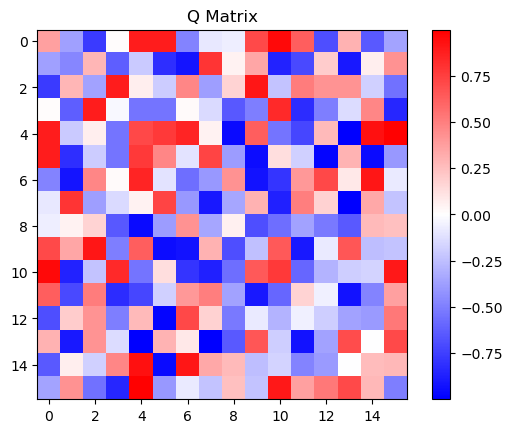

In [32]:
# Plot the Q matrix # 畫出Q矩陣
max_abs_val = np.max(np.abs(Q_arr))
plt.figure()
plt.imshow(Q_arr, cmap="bwr", vmin=-max_abs_val, vmax=max_abs_val)
plt.colorbar()
plt.title("Q Matrix")

In [33]:
# Try using a smaller "var_num" and check if it gives the same energy as you calculated
config = np.random.randint(0, 2, var_num, np.int8)
energy = bqm.energy(config)
print(energy)

-0.350783941117466


In [21]:
class FactorizationMachine(nn.Module):
    """
    Factorization Machine model implemented in PyTorch.
    這個類別包含了模型架構與輔助方法，用於損失計算、BQM 轉換、繪圖，以及模型的儲存與載入。
    """

    def __init__(self, input_size, factorization_size):
        """
        初始化 Factorization Machine 模型。
        
        input_size : 特徵數量。
        factorization_size : the factorization的維度。\n"
        """
        super().__init__()
        self.input_size = input_size
        self.factorization_size = factorization_size

        # Model parameters
        self.bias = nn.Parameter(torch.randn(1))  # w_0: global bias
        self.linear_weights = nn.Parameter(torch.randn(input_size))  # w: linear weights
        self.V = nn.Parameter(torch.randn(input_size, factorization_size))  # V: factorization matrix
        
        # To store the optimizer, similar to the original's trainer
        self.optimizer = None
    def init_params(self, mean=0.0, std=1.0):
        """
        使用常態分布初始化模型參數。
    Args:
        mean : Mean of the normal distribution.
        std  : Standard deviation of the normal distribution.
        """
        with torch.no_grad():
            self.bias.data.normal_(mean, std)
            self.linear_weights.data.normal_(mean, std)
            self.V.data.normal_(mean, std)

    def forward(self, xs):
        """
        公式為 : y(x) = w_0 + Σ(w_i * x_i) + Σ_i Σ_{j>i} <v_i, v_j> x_i x_j

        Args:
            xs : Input tensor 的形狀 (batch_size, input_size)..
        Returns:
            torch.Tensor: The model output.
        """
        if isinstance(xs, np.ndarray):
            xs = torch.from_numpy(xs).float()

        # Linear terms: Σ(w_i * x_i)
        linear_part = torch.matmul(xs, self.linear_weights)

        # 0.5 * Σ_f ( (Σ_i v_if * x_i)^2 - Σ_i (v_if^2 * x_i^2) )
        # Assuming binary inputs (0 or 1), x_i^2 = x_i, so the formula simplifies.
        # The implementation below is general for real-valued inputs.
        interactions_part1 = torch.matmul(xs, self.V).pow(2).sum(1)
        interactions_part2 = torch.matmul(xs.pow(2), self.V.pow(2)).sum(1)
        
        interactions = 0.5 * (interactions_part1 - interactions_part2)

        # Total output
        output = self.bias + linear_part + interactions
        return output

    def loss(self, dataset):
        """
        計算均方誤差（MSE）損失。
            - 公式：mean((ys - outputs)**2)
            
        dataset：一個列表或元組 [xs, ys]，其中 xs 和 ys 為 NumPy 陣列。
        """
        xs = torch.from_numpy(dataset[0]).float()
        ys = torch.from_numpy(dataset[1]).float()
        
        outputs = self(xs)
        return F.mse_loss(outputs, ys).item()

    def get_bhQ(self):
        """
        從模型參數中取偏置（b）、線性係數（h）和二次係數（Q），並以 NumPy 陣列的形式回傳。
            Returns：
                元組（b, h, Q）：
                    b：偏置項。
                    h：線性係數。
                    Q：上三角的二次項係數矩陣。
        """
        b = self.bias.data.cpu().numpy()[0]
        h = self.linear_weights.data.cpu().numpy()
        V = self.V.data.cpu().numpy()
        
        # Q_ij = <v_i, v_j>
        Q_full = V @ V.T
        # Extract the upper triangular part, excluding the diagonal (k=1)
        Q = np.triu(Q_full, k=1)
        
        return b, h, Q

    def get_bhQ_scaled(self):
        """
        取得模型參數（b、h、Q），並以線性或二次係數中的最大絕對值對它們進行縮放。
            Returns：
                 元組 (b, h, Q)，為經過縮放後的參數組合。
        """
        b, h, Q = self.get_bhQ()
        
        h_max = np.max(np.abs(h)) if h.size > 0 else 0
        Q_max = np.max(np.abs(Q)) if Q.size > 0 else 0
        scaling_factor = max(h_max, Q_max)
        
        if scaling_factor > 1e-9:  # Avoid division by zero
            b /= scaling_factor
            h /= scaling_factor
            Q /= scaling_factor

        return b, h, Q

    def bqm(self, use_scaled=False):
        """
        根據模型參數建立一個 dimod 的 BinaryQuadraticModel（BQM）。
            參數：
                use_scaled ：若為 True，使用已縮放的參數。預設為 False。
            Returns：
                dimod.BinaryQuadraticModel：模型對應的 BQM 表示。
        """
        if use_scaled:
            b, h, Q = self.get_bhQ_scaled()
        else:
            b, h, Q = self.get_bhQ()
        
        return dimod.BinaryQuadraticModel(h, Q, b, dimod.BINARY)

    def plot_Q_matrix(self, show_fig=False, path_fig="Q_matrix_heatmap.png", save_fig=True, path_data="Q_matrix.npy", save_data=True, use_scaled=False):
        """
        產生並可選擇儲存或顯示 QUBO 矩陣的熱力圖。
        QUBO 矩陣的對角線表示線性項（h），非對角線部分表示二次項（Q₍ᵢⱼ₎）。
        """
        if use_scaled:
            b, h, Q = self.get_bhQ_scaled()
        else:
            b, h, Q = self.get_bhQ()
        
        # Construct the full symmetric QUBO matrix
        qubo_matrix = Q + Q.T
        np.fill_diagonal(qubo_matrix, h)
        
        if save_data:
            np.save(path_data, qubo_matrix)

        if show_fig or save_fig:
            if qubo_matrix.size == 0:
                print("Cannot plot empty Q matrix.")
                return

            max_abs_val = np.max(np.abs(qubo_matrix))
            plt.figure(figsize=(10, 8))
            plt.imshow(qubo_matrix, cmap="bwr", vmin=-max_abs_val if max_abs_val > 0 else -1, vmax=max_abs_val if max_abs_val > 0 else 1)
            plt.colorbar(label="Coefficient Value")
            plt.title("QUBO Matrix Heatmap")
            plt.xlabel("Variable Index")
            plt.ylabel("Variable Index")

            if save_fig:
                plt.savefig(path_fig, bbox_inches='tight', transparent=True)
            if show_fig:
                plt.show()
            
            if not show_fig:
                plt.close()

    def save_model(self, path="model.pth"):
        
        torch.save(self.state_dict(), path)
        
        if self.optimizer is not None:
            torch.save(self.optimizer.state_dict(), path + ".optimizer")

    @staticmethod
    def load_model(input_size, factorization_size, path="model.pth", learning_rate=0.01):
        
        model = FactorizationMachinePyTorch(input_size=input_size, factorization_size=factorization_size)
        model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
        model.eval()

        # Initialize a new optimizer for the loaded model
        model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Try to load the optimizer state
        try:
            model.optimizer.load_state_dict(torch.load(path + ".optimizer", map_location=torch.device('cpu')))
        except FileNotFoundError:
            print("Optimizer state file not found. A new optimizer was initialized.")

        return model

    def fit(self, xs, ys, num_epoch=1000, learning_rate=1e-2, verbose=True):
        """
    Trains the Factorization Machine model using mean squared error loss.

    Args:
        xs : Input features.
        ys : Target values.
        num_epoch : Number of training epochs.
        learning_rate : Learning rate for optimizer.
        """
        xs_tensor = torch.from_numpy(xs).float()
        ys_tensor = torch.from_numpy(ys).float()

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epoch):
            self.optimizer.zero_grad()
            output = self(xs_tensor)
            loss = F.mse_loss(output, ys_tensor)
            loss.backward()
            self.optimizer.step()

            if verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epoch}, Loss: {loss.item():.6f}")


In [22]:
# Generate the training and testing dataset for FM
dataset_size = 10_000
xs = np.random.randint(0, 2, (dataset_size, var_num), np.int8)
ys = np.array([bqm.energy(x) for x in xs], np.float64)

In [24]:
# Initialize FM
K = var_num    # latent factor
model = FactorizationMachine(input_size=var_num, factorization_size=K)
model.init_params(mean=0.0, std=1.0)


# Train FM
num_epoch = 5_000
learning_rate = 1e-2
model.fit(xs, ys, num_epoch=5000, learning_rate=1e-2)

Epoch 100/5000, Loss: 40.983536
Epoch 200/5000, Loss: 16.079931
Epoch 300/5000, Loss: 7.629569
Epoch 400/5000, Loss: 4.308941
Epoch 500/5000, Loss: 2.670841
Epoch 600/5000, Loss: 1.680672
Epoch 700/5000, Loss: 1.062015
Epoch 800/5000, Loss: 0.703717
Epoch 900/5000, Loss: 0.500957
Epoch 1000/5000, Loss: 0.378305
Epoch 1100/5000, Loss: 0.298107
Epoch 1200/5000, Loss: 0.242325
Epoch 1300/5000, Loss: 0.201301
Epoch 1400/5000, Loss: 0.169508
Epoch 1500/5000, Loss: 0.143753
Epoch 1600/5000, Loss: 0.122190
Epoch 1700/5000, Loss: 0.103743
Epoch 1800/5000, Loss: 0.087765
Epoch 1900/5000, Loss: 0.073851
Epoch 2000/5000, Loss: 0.061729
Epoch 2100/5000, Loss: 0.051201
Epoch 2200/5000, Loss: 0.042108
Epoch 2300/5000, Loss: 0.034311
Epoch 2400/5000, Loss: 0.027683
Epoch 2500/5000, Loss: 0.022102
Epoch 2600/5000, Loss: 0.017452
Epoch 2700/5000, Loss: 0.013622
Epoch 2800/5000, Loss: 0.010503
Epoch 2900/5000, Loss: 0.007997
Epoch 3000/5000, Loss: 0.006008
Epoch 3100/5000, Loss: 0.004452
Epoch 3200/5000

In [25]:
# Test FM
test_num = 50_000
xs = np.random.randint(0, 2, (test_num, var_num), np.int8)
ys = np.array([bqm.energy(x) for x in xs], np.float64)                 # label
ys_pred = np.array([model.bqm().energy(x) for x in xs], np.float64)    # predict from FM

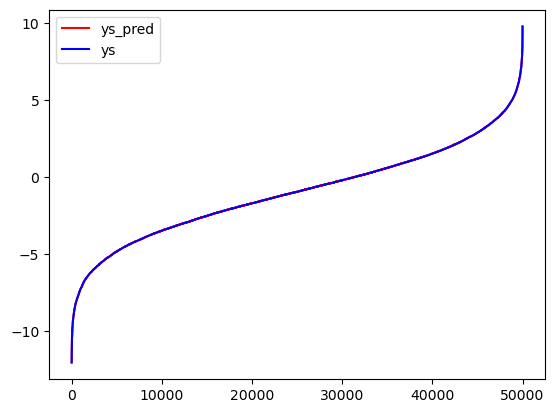

In [26]:
# Sort ascendingly based on ys
sorted_indices = np.argsort(ys)
ys = ys[sorted_indices]
ys_pred = ys_pred[sorted_indices]

# If the FM is correct and well-trained, these two line charts will have similar values
plt.plot(ys_pred, color="red", label="ys_pred")
plt.plot(ys, color="blue", label="ys")
plt.legend()
plt.show()